### United Airlined Round 3 Interview: Data Science Case Study

#### Submission By: Abdul Hannan

#### Date: Sept 14, 2022

Let us start with importing necessary libraries and reading the data in.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
import scipy.stats as stats

import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import matplotlib.pyplot as plt  


In [2]:
path = "C:\\Users\\hanna\\Downloads\\United_Airlines_Analytics_Exercise_2022\\United_Airlines_Analytics_Exercise\\CDC_SURVEY_CT_NJ_NY_2014.txt"

df = pd.read_csv(path, sep="\t")

df.head()

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_RFBLDS2,_RFSIGM2,_AIDTST3,_IMPEDUC,_IMPMRTL,_IMPHOME,RCSBRAC1,RCSRACE1,RCHISLA1,RCSBIRTH
0,9.0,5.0,5212014,5,21,2014,1200.0,2.014000e+09,2.014000e+09,1.0,...,NaN,NaN,9.0,6.0,5.0,2.0,NaN,NaN,NaN,NaN
1,9.0,9.0,10252014,10,25,2014,1200.0,2.014000e+09,2.014000e+09,1.0,...,2.0,1.0,1.0,5.0,2.0,1.0,NaN,NaN,NaN,NaN
2,9.0,9.0,11082014,11,8,2014,1200.0,2.014000e+09,2.014000e+09,1.0,...,NaN,NaN,2.0,4.0,6.0,1.0,NaN,NaN,NaN,NaN
3,9.0,9.0,9272014,9,27,2014,1200.0,2.014000e+09,2.014000e+09,1.0,...,2.0,1.0,2.0,6.0,4.0,2.0,NaN,NaN,NaN,NaN
4,9.0,1.0,1262014,1,26,2014,1200.0,2.014000e+09,2.014000e+09,1.0,...,NaN,NaN,NaN,6.0,1.0,2.0,NaN,NaN,NaN,NaN


We see that a lot of our variables are numerical, let us see if we have any that are categorical.

In [3]:
df.describe(include = 'object')

,DLYOTHER
count,794
unique,686
top,no insurance
freq,15


- DLYOTHER - Delayed Getting Medical Care Other Response


In [4]:
df['DLYOTHER'].value_counts()

no insurance                15
cost                        13
COST                        12
money                        6
didnt have time              6
                            ..
 time, work obligations.     1
COVERAGE TO CARE FOR MOM     1
orm).                        1
SCHEDULING OF APPT           1
i was just too busy          1
Name: DLYOTHER, Length: 686, dtype: int64

We will drop this column for times sake so we do not have to deal with 686 different values (and one hot encoding), When making the train and test sets.

Another thing, we need to work on is changing the NaNs values to 0. Otherwise we will get a ValueError.

In [5]:
df.fillna(0, inplace = True)

In [6]:
df.head(3)

,_STATE,FMONTH,IDATE,IMONTH,IDAY,IYEAR,DISPCODE,SEQNO,_PSU,CTELENUM,...,_RFBLDS2,_RFSIGM2,_AIDTST3,_IMPEDUC,_IMPMRTL,_IMPHOME,RCSBRAC1,RCSRACE1,RCHISLA1,RCSBIRTH
0,9.0,5.0,5212014,5,21,2014,1200.0,2.014000e+09,2.014000e+09,1.0,...,0.0,0.0,9.0,6.0,5.0,2.0,0.0,0.0,0.0,0.0
1,9.0,9.0,10252014,10,25,2014,1200.0,2.014000e+09,2.014000e+09,1.0,...,2.0,1.0,1.0,5.0,2.0,1.0,0.0,0.0,0.0,0.0
2,9.0,9.0,11082014,11,8,2014,1200.0,2.014000e+09,2.014000e+09,1.0,...,0.0,0.0,2.0,4.0,6.0,1.0,0.0,0.0,0.0,0.0


#### 1) How does health status, represent by average number of days with bad physical health in the past month (PHYSHLTH), differ by state? Provide an indication of distribution using whatever statistics or chars you find suitable.

Since we are working with past month, we will work with values from 1 - 30, and remove 77.0, 88.0, 99.0 from the equation. Then we can use groupby function on states to get the values for each state. 

In [7]:
len(df['_STATE'].value_counts())

3

In [8]:
df['_STATE'].value_counts()

34.0    13045
9.0      7950
36.0     6865
Name: _STATE, dtype: int64

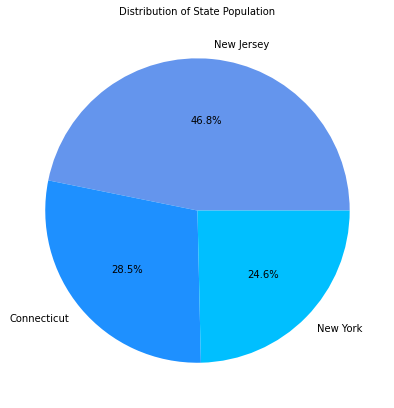

In [58]:
#visualization
plt.figure(figsize=(7,7))
plt.pie(df['_STATE'].value_counts(), labels = ['New Jersey', 'Connecticut', 'New York'], colors = ['cornflowerblue','dodgerblue','deepskyblue'], autopct='%1.1f%%')
plt.title('Distribution of State Population',color='black',fontsize=10)
plt.show()

In [10]:
len(df['PHYSHLTH'].value_counts())

33

In [11]:
df_filter = df[df['PHYSHLTH'] != 88.0] 
df_filtere = df_filter[df_filter['PHYSHLTH'] != 77.0] 
df_filtered = df_filtere[df_filtere['PHYSHLTH'] != 99.0] 


len(df_filtered['PHYSHLTH'].value_counts())

30

_STATE
9.0     10.430941
34.0    11.732769
36.0    10.929700
Name: PHYSHLTH, dtype: float64


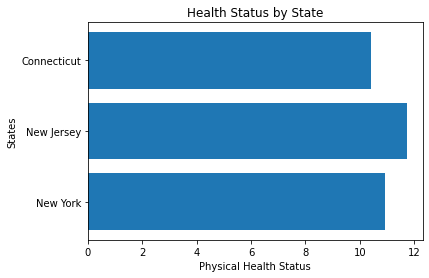

Median values Per State
_STATE
9.0     5.0
34.0    6.0
36.0    5.0
Name: PHYSHLTH, dtype: float64


In [61]:
print(df_filtered.groupby('_STATE')['PHYSHLTH'].agg(pd.Series.mean))

state_health = pd.DataFrame(df_filtered.groupby('_STATE')['PHYSHLTH'].mean())
state_health.reset_index(inplace=True)

fig, ax = plt.subplots()

labels = ('Connecticut', 'New Jersey', 'New York')
y_pos = np.arange(len(labels))

ax.barh(y_pos, state_health['PHYSHLTH'])
ax.set_yticks(y_pos, labels=labels)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Physical Health Status')
ax.set_ylabel('States')
ax.set_title('Health Status by State')
plt.show()


df_filtered = df_filtered.sort_values(['PHYSHLTH'], ascending=[False])
print("Median values Per State")
print(df_filtered.groupby('_STATE')['PHYSHLTH'].agg(pd.Series.median))

ANSWER: While New York (NY) has the most population out of all, a lot of the data is from Jersey. The statistical method I used to find the difference is mean. New Jersey has the worst heath status out of all but only by decimals. 

- 9  Connecticut

- 34 New Jersey

- 36 New York


##### 2) How do you know if the above difference between states is statistically significant?

- Research Hypothesis: There is a statistical significance between the states (PHYSHLTH) (If P-value is less than 0.05)
- Null Hypothese: There is no statistical significance between the states (PHYSHLTH) (If P-value is greater than 0.05)




In [14]:
c_state = df_filtered[df_filtered['_STATE'] == 9.0]
ny_state = df_filtered[df_filtered['_STATE'] == 36.0]
nj_state = df_filtered[df_filtered['_STATE'] == 34.0]

# Perform the ANOVA
stats.f_oneway(c_state['PHYSHLTH'], ny_state['PHYSHLTH'], nj_state['PHYSHLTH'])

F_onewayResult(statistic=12.086743040649436, pvalue=5.72205849728279e-06)

In [15]:
# Test 1 --- connecticut vs ny  -  (NOT SIGNIFICANT)
t, p = ttest_ind(c_state['PHYSHLTH'], ny_state['PHYSHLTH'])
print(f't-statistic: {t}, p-value: {p}')


# Test 2 --- connecticut vs nj  -  (SIGNIFICANT)
t, p = ttest_ind(c_state['PHYSHLTH'], nj_state['PHYSHLTH'])
print(f't-statistic: {t}, p-value: {p}')


# Test 3 --- connecticut vs ny  -  (SIGNIFICANT)
t, p = ttest_ind(ny_state['PHYSHLTH'], nj_state['PHYSHLTH'])
print(f't-statistic: {t}, p-value: {p}')


t-statistic: -1.6629667092157414, p-value: 0.09638028159028383
t-statistic: -4.7381497711112335, p-value: 2.2003311846873494e-06
t-statistic: -2.888087095607205, p-value: 0.0038881913148048363


The ANOVA test output yields an F-statistic of 12.087 and a p-value of 0.00000572205849728279, which is significantly less than our threshold of 0.05, indicating that the difference between states is statistically significant.

Another approach was conducting T-test using two groups, hence three test in total. One test (Connecticut & NY) came out to out as having no statistical significance as the P-value was more than 0.05, thus accepting the null hypothesis but not with too much confidence, as the value is still lower than 0.10.

#### 3) Digging Deeper into the data, what are the top predictor variables impacting health (i.e. demographics, behaviors, previous illness, etc.)?

In order to create a model, we will need a training and test set, and we need to get rid of the column with textual data. 

In [18]:


X = df.drop(['PHYSHLTH', 'DLYOTHER'], axis = 1)
y = df['PHYSHLTH']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 321)



In [34]:
print("\n")
print("train:", X_train.shape, y_train.shape) 

print("\n")
print("test", X_test.shape, y_test.shape) 

X_train.columns.contains('PHYSHLTH')



train: (19502, 256) (19502,)


test (8358, 256) (8358,)


<ipython-input-34-3290129f38ea>:8: FutureWarning: The 'contains' method is deprecated and will be removed in a future version. Use 'key in index' instead of 'index.contains(key)'
  X_train.columns.contains('PHYSHLTH')


False

In [50]:
rf = RandomForestClassifier()      
rf = rf.fit(X_train, y_train)

values = rf.feature_importances_
ind = np.argsort(values)[::-1]

feature = []
importance = list()
name = []

# Print the feature ranking
print("Feature ranking:")
for i in range(X_train.shape[1]):
#     print(f"{i+1}. feature #{ind[i]} ({values[ind[i]]})")
    feature.append(ind[i])
    importance.append(values[ind[i]])
    name.append(df.columns[ind[i]])
    
# Creating a DF with most important features    
feature_importance = pd.DataFrame({'feature': feature, 'importance': importance, 'name': name})
feature_importance.reset_index(drop=True, inplace=True)

feature_importance = pd.DataFrame(feature_importance.sort_values('importance', ascending = False).head(11))

print("Before Deleting the target variable")
print(feature_importance)

feature_importance = feature_importance.drop([1])

print("After Deleting the target variable")
print(feature_importance)

Feature ranking:
Before Deleting the target variable
    feature  importance      name
0        19    0.145370  MENTHLTH
1        18    0.028596  PHYSHLTH
2        17    0.025219   GENHLTH
3       199    0.018189  _IMPCRAC
4       121    0.017165  NOCOV121
5         2    0.014719     IDATE
6       222    0.013866      HTM4
7        56    0.013433  PREGNANT
8         4    0.013367      IDAY
9         7    0.013345     SEQNO
10        8    0.013231      _PSU
After Deleting the target variable
    feature  importance      name
0        19    0.145370  MENTHLTH
2        17    0.025219   GENHLTH
3       199    0.018189  _IMPCRAC
4       121    0.017165  NOCOV121
5         2    0.014719     IDATE
6       222    0.013866      HTM4
7        56    0.013433  PREGNANT
8         4    0.013367      IDAY
9         7    0.013345     SEQNO
10        8    0.013231      _PSU


C:\Users\hanna\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'RF Feature Importance')

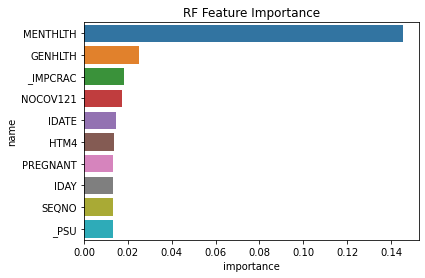

In [63]:
sns.barplot(feature_importance['importance'][:10], feature_importance['name'][:10])
plt.title("RF Feature Importance")

In [23]:

# configure to select all features
fs = SelectKBest(score_func=f_regression, k=10)


# learn from training data
fs.fit(X_train, y_train)


# transform train data
X_train_fs = fs.transform(X_train)
# transform test data
X_test_fs = fs.transform(X_test)


# print(f"X_train: {X_train_fs}")
# print(f"X_test: {X_test_fs}")
print(f"fs: {fs}")



feature_1 = []
importance_1 = []
name_1 = []

# what are scores for the features
for i in range(len(fs.scores_)):
#     print('Feature %d: %f' % (i+1, fs.scores_[i]))
    feature_1.append(i+1)
    importance_1.append(fs.scores_[i])
    name_1.append(df.columns[i])
    
# Creating a DF with most important features    
feature_importance_1 = pd.DataFrame({'feature': feature_1, 'importance': importance_1, 'name': name_1})
feature_importance_1.reset_index(drop=True, inplace=True)

feature_importance_1.sort_values('importance', ascending = False).head(10)

fs: SelectKBest(score_func=<function f_regression at 0x25E05A48>)


,feature,importance,name
19,20,3496.184328,MENTHLTH
17,18,1888.604456,GENHLTH
18,19,1318.061468,PHYSHLTH
205,206,560.507702,_CASTHM1
199,200,489.431592,_IMPCRAC
56,57,440.137212,PREGNANT
118,119,303.147074,HLTHCVR1
35,36,254.658752,HAVARTH3
34,35,248.806303,CHCCOPD1
45,46,245.946130,EDUCA


C:\Users\hanna\AppData\Local\Programs\Python\Python38-32\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'LR Feature Importance')

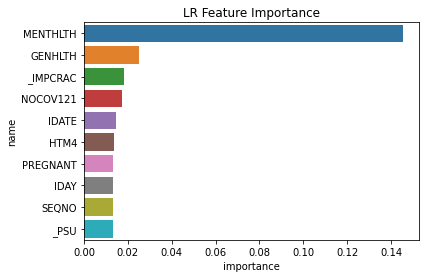

In [62]:
sns.barplot(feature_importance['importance'][:10], feature_importance['name'][:10])
plt.title("LR Feature Importance")

The top predictor variables impacting health:

1. MENTHLTH    - Mental Health
2. GENHLTH     - General Health
3. _IMPCRAC    - Imputed Child Race/Ethnicity 
4. NOCOV121    - In the PAST 12 MONTHS, time you did NOT have ANY health insurance or coverage?
5. IDATE       - Interview Date
6. HTM4        - Reported height in meters
7. PREGNANT    - Pregnancy Question 
8. IDAY        - Interview Day
9. SEQNO       - Annual Sequence Number
10. _PSU       -  Primary Sampling Unit (Equal to Annual Sequence Number)




#### 4) If you had additional time, what other types of data mininng techniques and / or analytical modeling would you explore with this dataset?

I would first start with cleaning the data and dealing with categorical values. Second, I would Standardize the data so we can convert it to a common factor. My next approach would be to conduct a Principle Component Analysis.